# Obtain Uniprot IDs for all human kinases

The definition of _kinase_ is not as straightforward as one could think. Throughout the literature you can find several manuscripts that list an authoritative list of kinases to query in an assay or include in domain-specific database. Surprisingly, the criteria used to nominate how a kinase makes to the list or not is not consistent or obvious, and this results into slightly divergent definitions of what the human kinome really represents. In this notebook we aim to discuss these discrepancies and figure out a way to consistently agree on a definition for our future kinase-centric studies.

> To that avail, we will query online databases, web services and documents using `urllib`, `requests`, `beautifulsoup4` and `pandas`.

In [1]:
# Some imports and helper globals
import urllib.request
from pathlib import Path

import requests
import bs4
import pandas as pd
from matplotlib import pyplot as plt

REPO = (Path(_dh[-1]) / "..").resolve()
DATA = REPO / 'data'

SOURCES = {}

## 1. Enumerate all possible sources for human kinases

There are several nomenclatures commonly used to refer to kinases: xName, Manning, HGNC... While there are some overlaps, there's no uniquely identifying naming system, so instead we will use Uniprot's identifiers as our primary keys. These can be mapped to other identifiers whenever available.

There are several sources that can be used to identify the human kinome in Uniprot:

* __A)__ [KinHub](http://kinhub.org/kinases.html)
* __B)__ [KLIFS](https://klifs.vu-compmedchem.nl/)
* __C)__ [Pkinfam](https://www.uniprot.org/docs/pkinfam.txt) - Uniprot's _Human and mouse protein kinases: classification and index_.
* __D1)__ Dunbrack's structurally validated kinase alignment
* __D2)__ Dunbrack's `kincore` webserver
* __E)__  Kinbase
* __F)__ Handcrafted UniProt query



### A) KinHub

[Kinhub.org](http://kinhub.org/kinases.html) maintains a HTML table in its webpage that can be retrieved with `requests` and `beautifulsoup`.

In [2]:
r = requests.get("http://kinhub.org/kinases.html")
r.raise_for_status()
html = bs4.BeautifulSoup(r.text)

In [3]:
table = html.find('table')
columns = [cell.text.strip() for cell in table.find('thead').find_all('th')]
records = [[cell.text.strip() for cell in row.find_all('td')] for row in table.find('tbody').find_all('tr')]
kinhub = SOURCES['kinhub'] = pd.DataFrame.from_records(records, columns=columns).sort_values(by="xName")
kinhub

,xName,Manning Name,HGNC Name,Kinase Name,Group,Family,SubFamily,UniprotID
336,AAK1,AAK1,AAK1,AP2-associated protein kinase 1,Other,NAK,,Q2M2I8
0,ABL1,ABL,ABL1,Tyrosine-protein kinase ABL1,TK,Abl,,P00519
24,ABL2,ARG,ABL2,Abelson tyrosine-protein kinase 2,TK,Abl,,P42684
529,ABR,ABR,ABR,Active breakpoint cluster region-related protein,Atypical,BCR,,Q12979
1,ACK,ACK,TNK2,Activated CDC42 kinase 1,TK,Ack,,Q07912
...,...,...,...,...,...,...,...,...
274,p38g,p38g,MAPK12,Mitogen-activated protein kinase 12,CMGC,MAPK,p38,P53778
209,p70S6K,p70S6K,RPS6KB1,Ribosomal protein S6 kinase beta-1,AGC,RSK,RSKp70,P23443
210,p70S6Kb,p70S6Kb,RPS6KB2,Ribosomal protein S6 kinase beta-2,AGC,RSK,RSKp70,Q9UBS0
477,skMLCK,skMLCK,MYLK2,Myosin light chain kinase 2,CAMK,MLCK,,Q9H1R3


### B) KLIFS

[KLIFS](https://klifs.vu-compmedchem.nl/) maintains their own internal list of kinase names as part of their database. This can be retrieved via their JSON API as follows. It requires two steps: 1) getting the list of names, 2) getting the metadata associated to each name. All of this is then dumped into a dataframe.

In [4]:
r = requests.get("https://klifs.vu-compmedchem.nl/api/kinase_names?species=HUMAN")
r.raise_for_status()
data = r.json()
all_ids = [record["kinase_ID"] for record in data]

In [5]:
r = requests.get(f"https://klifs.vu-compmedchem.nl/api/kinase_information?kinase_ID={','.join(map(str, all_ids))}")
r.raise_for_status()
data = r.json()

In [6]:
items = []
for record in data:
    items.append({
        "KLIFS Name": record["name"],
        "HGNC Name": record["HGNC"],
        "Family": record["family"],
        "Group": record["group"],
        "Class": record["kinase_class"],
        "Kinase Name": record["full_name"],
        "UniprotID": record["uniprot"],
        "IUPHAR": record["iuphar"],
        "Pocket": record["pocket"],
        "KLIFS ID": record["kinase_ID"]
    })
klifs = SOURCES['KLIFS'] = pd.DataFrame.from_dict(items).sort_values(by="KLIFS Name")
klifs

,KLIFS Name,HGNC Name,Family,Group,Class,Kinase Name,UniprotID,IUPHAR,Pocket,KLIFS ID
276,AAK1,AAK1,NAK,Other,BIKE,AP2 associated kinase 1,Q2M2I8,1921,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,277
391,ABL1,ABL1,Abl,TK,,"ABL proto-oncogene 1, non-receptor tyrosine ki...",P00519,1923,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,392
392,ABL2,ABL2,Abl,TK,,"ABL proto-oncogene 2, non-receptor tyrosine ki...",P42684,1924,HKLGGGQYGEVYVVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIVTE...,393
393,ACK,TNK2,Ack,TK,,"tyrosine kinase, non-receptor, 2",Q07912,2246,EKLGDGSFGVVRRVAVKCLDFIREVNAMHSLDRNLIRLYGVKMVTE...,394
522,ACTR2,ACVR2A,STKR,TKL,Type2,activin A receptor type IIA,P27037,1791,EVKARGRFGCVWKVAVKIFSWQNEYEVYSLPGENILQFIGAWLITA...,523
...,...,...,...,...,...,...,...,...,...,...
251,p38g,MAPK12,MAPK,CMGC,p38,mitogen-activated protein kinase 12,P53778,1501,QPVGSGAYGAVCSVAIKKLRAYRELRLLKHMRENVIGLLDVYLVMP...,252
50,p70S6K,RPS6KB1,RSK,AGC,p70,ribosomal protein S6 kinase B1,P23443,1525,RVLGKGGYGKVFQFAMKVLHTKAERNILEEVKPFIVDLIYAYLILE...,51
51,p70S6Kb,RPS6KB2,RSK,AGC,p70,ribosomal protein S6 kinase B2,Q9UBS0,1526,RVLGKGGYGKVFQYAMKVLHTRAERNILESVKPFIVELAYAYLILE...,52
154,skMLCK,MYLK2,MLCK,CAMK,,myosin light chain kinase 2,Q9H1R3,1553,EALGGGKFGAVCTLAAKVIMVLLEIEVMNQLNRNLIQLYAAVLFME...,155


### C) Pkinfam

UniProt maintains [a txt file](https://www.uniprot.org/docs/pkinfam.txt) with a kinase index: `pkinfam`. We can try to parse it and see what information we have there.

In [7]:
r = requests.get("https://www.uniprot.org/docs/pkinfam.txt")
r.raise_for_status()
text = r.text

In [8]:
items = []
current_category = None
lines = iter(text.splitlines())
for line in lines:
    if line.startswith("==="):  # this is a header
        line = next(lines)
        current_category = line.strip()
        next(lines)
        next(lines)
        continue
    if not line.strip() or not current_category or '_HUMAN' not in line:
        continue
    if line.startswith("---") and current_category:
        break
    
    fields = line.split()
    name = fields[0]
    uniprot_id = fields[2].replace("(", "").replace(")", "")
    items.append({
        'Name': name,
        'Family': current_category,
        'UniprotID': uniprot_id,
    })
pkinfam = SOURCES['pkinfam'] = pd.DataFrame.from_dict(items).sort_values(by="Name")
pkinfam

,Name,Family,UniprotID
403,AAK1,Other,Q2M2I8
313,AATK,Tyr protein kinase family,Q6ZMQ8
314,ABL1,Tyr protein kinase family,P00519
315,ABL2,Tyr protein kinase family,P42684
279,ACVR1,TKL Ser/Thr protein kinase family,Q04771
...,...,...,...
481,WNK2,Other,Q9Y3S1
482,WNK3,Other,Q9BYP7
483,WNK4,Other,Q96J92
401,YES1,Tyr protein kinase family,P07947


### D1) Dunbrack's structurally validated kinase alignment

Dataset extracted from:

> Modi, V., Dunbrack, R.L. A Structurally-Validated Multiple Sequence Alignment of 497 Human Protein Kinase Domains. Sci Rep 9, 19790 (2019). https://doi.org/10.1038/s41598-019-56499-4

In [9]:
url = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-019-56499-4/MediaObjects/41598_2019_56499_MOESM4_ESM.txt"
dunbrack_msa = SOURCES["dunbrack_msa"] = pd.read_csv(url, sep=r"\s+").rename(columns={'5_Uni_acc': "UniprotID"})
dunbrack_msa

,1_Group,2_Gene,3_HGNC,4_Uni_entry,UniprotID,6_Domain_begin,7_Domain_end,8_Domain_length,9_Largest_insert_length,10_PDB_validation,11_Conformational_state,12_Dihedral_state,13_Group_in_Uni,14_Group_in_Manning,15_Synonymn
0,AGC,AKT1,HGNC:391,AKT1_HUMAN,P31749,150,408,259,9,6NPZB,DFGin,BLAminus,AGC,AGC,"PKB,RAC"
1,AGC,AKT2,HGNC:392,AKT2_HUMAN,P31751,152,409,258,9,3E8DB,DFGin,BLAminus,AGC,AGC,NaN
2,AGC,AKT3,HGNC:393,AKT3_HUMAN,Q9Y243,148,405,258,9,NaN,NaN,NaN,AGC,AGC,PKBG
3,AGC,CDC42BPA,HGNC:1737,MRCKA_HUMAN,Q5VT25,77,343,267,14,NaN,NaN,NaN,AGC,AGC,KIAA0451
4,AGC,CDC42BPB,HGNC:1738,MRCKB_HUMAN,Q9Y5S2,76,342,267,14,5OTFA,DFGin,BLAminus,AGC,AGC,KIAA1124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,TYR,TYK2_1,HGNC:12440,TYK2_HUMAN,P29597,589,868,280,26,3ZONA,DFGin,NaN,TYR,TYR,NaN
493,TYR,TYK2_2,HGNC:12440,TYK2_HUMAN,P29597,897,1171,275,21,4GVJA,DFGin,BLAminus,TYR,TYR,NaN
494,TYR,TYRO3,HGNC:12446,TYRO3_HUMAN,Q06418,518,788,271,10,NaN,NaN,NaN,TYR,TYR,"BYK,DTK,RSE,SKY,TIF"
495,TYR,YES1,HGNC:12841,YES_HUMAN,P07947,277,528,252,10,NaN,NaN,NaN,TYR,TYR,YES


### D2) Dunbrack's `kincore` webserver

The [Kinase Conformation Resource](http://dunbrack3.fccc.edu/kincore/) (`kincore`) is the accompanying website for 2019's kinase-focused works by Modi and Dunbrack:

> Defining a new nomenclature for the structures of active and inactive kinases. Vivek Modi and Roland L. Dunbrack, PNAS 2019, 116(14) 6818-6827.
> Structurally-Validated Multiple Sequence Alignment of 497 Human Protein Kinase Domains. Vivek Modi and Roland L. Dunbrack, Sci Rep 2019, 9, 19790.

All kinases thereby listed are programmably accessible via a TSV file in this url:

```
http://dunbrack3.fccc.edu/kincore/static/downloads/text-files/Human_Allgroups_Allspatials_Alldihedrals_All.tsv
```

In [10]:
url = "http://dunbrack3.fccc.edu/kincore/static/downloads/text-files/Human_Allgroups_Allspatials_Alldihedrals_All.tsv"
dunbrack_kincore = SOURCES["dunbrack_kincore"] = pd.read_csv(url, sep="\t")
dunbrack_kincore

,Organism,Group,Gene,UniprotID,PDB,Method,Resolution,Rfac,FreeRfac,SpatialLabel,DihedralLabel,C-helix,Ligand,LigandType,DFG_Phe,Edia_X_O,Edia_Asp_O,Edia_Phe_O,Edia_Gly_O,ProteinName
0,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6NPZB,XRAY,2.12,0.19,0.24,DFGin,BLAminus,in,No_ligand,No_ligand,293,0.85,0.88,0.94,0.91,RAC-alpha serine/threonine-protein kinase
1,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6NPZA,XRAY,2.12,0.19,0.24,DFGin,BLAminus,in,No_ligand,No_ligand,293,0.88,0.92,0.93,1.04,RAC-alpha serine/threonine-protein kinase
2,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6BUUB,XRAY,2.40,0.18,0.23,DFGin,BLAminus,in,No_ligand,No_ligand,293,0.92,0.78,0.99,0.86,RAC-alpha serine/threonine-protein kinase
3,Homo sapiens,AGC,AKT1,AKT1_HUMAN,6BUUA,XRAY,2.40,0.18,0.23,DFGin,BLAminus,in,No_ligand,No_ligand,293,0.92,0.81,1.00,0.87,RAC-alpha serine/threonine-protein kinase
4,Homo sapiens,AGC,AKT1,AKT1_HUMAN,3QKMA,XRAY,2.20,0.19,0.25,DFGin,BLAminus,in,SM9,Type1,293,1.07,0.98,0.94,1.00,RAC-alpha serine/threonine-protein kinase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,Homo sapiens,TYR,TYK2_1,TYK2_HUMAN,5TKDA,XRAY,1.92,0.19,0.21,DFGin,None,in,7GL,Type1,760,1.12,1.10,1.10,1.05,Non-receptor tyrosine-protein kinase TYK2
6572,Homo sapiens,TYR,TYK2_1,TYK2_HUMAN,3ZONA,XRAY,2.15,0.22,0.27,DFGin,None,in,IK1,Type1,760,0.97,0.99,0.96,0.95,Non-receptor tyrosine-protein kinase TYK2
6573,Homo sapiens,TYR,ZAP70,ZAP70_HUMAN,1U59A,XRAY,2.30,0.22,0.27,DFGin,BLAminus,in,STU,Type1,480,0.85,0.87,1.00,0.81,Tyrosine-protein kinase ZAP-70
6574,Homo sapiens,TYR,ZAP70,ZAP70_HUMAN,4K2RA,XRAY,3.00,0.21,0.29,DFGin,BLAplus,out,ANP,Type1,480,0.72,0.62,0.44,0.59,Tyrosine-protein kinase ZAP-70


Unfortunately, this database only contains kinases for which structural data is available, so the number of unique UniprotIDs is considerably smaller, so we won't include it in our analysis.

In [12]:
dunbrack_kincore["UniprotID"].unique().shape[0]

273

### E) KinBase

Kinase.com provides a `kinbase` dataset in form of Fasta sequences. However, it doesn't provide identifiers such as UniprotIDs, so we won't be able to use it directly. We can map the Gene names though...

> TODO: Map Gene names to Uniprot IDs

In [13]:
r = requests.get("http://kinase.com/kinbase/FastaFiles/Human_kinase_protein.fasta")
r.raise_for_status()

In [14]:
header = ["Gene", "Comment", "Sequence"]
records = []
for line in r.text.splitlines():
    line = line.strip()
    if not line:
        continue
    if line.startswith(">"):
        name, comment = line.split(None, 1)
        records.append({"Gene": name[1:], "Comment": comment, "sequence": ""})
    else:
        records[-1]["sequence"] += line
kinbase = pd.DataFrame.from_dict(records)
kinbase

,Gene,Comment,sequence
0,TTBK2_Hsap,(CK1/TTBK),MSGGGEQLDILSVGILVKERWKVLRKIGGGGFGEIYDALDMLTREN...
1,TTBK1_Hsap,(CK1/TTBK),MQCLAAALKDETNMSGGGEQADILPANYVVKDRWKVLKKIGGGGFG...
2,TSSK4_Hsap,(CAMK/TSSK),MGKGDVLEAAPTTTAYHSLMDEYGYEVGKAIGHGSYGSVYEAFYTK...
3,TSSK3_Hsap,(CAMK/TSSK),MEDFLLSNGYQLGKTIGEGTYSKVKEAFSKKHQRKVAIKVIDKMGG...
4,TSSK2_Hsap,(CAMK/TSSK),MDDATVLRKKGYIVGINLGKGSYAKVKSAYSERLKFNVAVKIIDRK...
...,...,...,...
511,ZAK_Hsap,(TKL/MLK/ZAK),MSSLGASFVQIKFDDLQFFENCGGGSFGSVYRAKWISQDKEVAVKK...
512,ZAP70_Hsap,(TK/Syk),MPDPAAHLPFFYGSISRAEAEEHLKLAGMADGLFLLRQCLRSLGGY...
513,DCLK3_Hsap,(CAMK/DCAMKL),MGKEPLTLKSIQVAVEELYPNKARALTLAQHSRAPSPRLRSRLFSK...
514,DCLK2_Hsap,(CAMK/DCAMKL),MASTRSIELEHFEERDKRPRPGSRRGAPSSSGGSSSSGPKGNGLIP...


Fortunately, in their new website, they do provide more information in an Excel spreadsheet. This doesn't include Uniprot IDs, but other identifies that can potentially be mapped to (in `Entrez_dbXrefs`).

In [15]:
kinbasex = pd.read_excel("http://kinase.com/static/colt/data/human/kinome/tables/Kincat_Hsap.08.02.xls")
kinbasex

,Name,SK,Group,Family,Subfamily,Pseudogene?,Header,cDNA,Protein,Kinase Domain,...,Entrez_Synonyms,Entrez_dbXrefs,Entrez_Chromosome,Entrez_map_location,Entrez_description,Entrez_gene_type,Entrez_symbol_from_nomenclature_authority,Entrez_full_name_from_NA,Entrez_Nomenclature_status (O=official; I=intermediate_,Entrez_other_designations
0,AKT1,SK018,AGC,Akt,NaN,N,AGC_AKT__SK018_AKT1,CGGCAGGACCGAGCGCGGCAGGCGGCTGGCCCAGCGCACGCAGCGC...,MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDVD...,FEYLKLLGKGTFGKVILVKEKATGRYYAMKILKKEVIVAKDEVAHT...,...,AKT|MGC99656|PKB|PRKBA|RAC|RAC-ALPHA,HGNC:391|MIM:164730|HPRD:01261,14,14q32.32|14q32.32,v-akt murine thymoma viral oncogene homolog 1,protein-coding,AKT1,v-akt murine thymoma viral oncogene homolog 1,O,RAC-alpha serine/threonine-protein kinase|muri...
1,AKT2,SK019,AGC,Akt,NaN,N,AGC_AKT__SK019_AKT2,AGCGGGGGCTGGGGGGAGGGGGCGGGGGGGGCCGCGCCGTGCTAGC...,MNEVSVIKEGWLHKRGEYIKTWRPRYFLLKSDGSFIGYKERPEAPD...,FDYLKLLGKGTFGKVILVREKATGRYYAMKILRKEVIIAKDEVAHT...,...,PKBBETA|PRKBB|RAC-BETA,HGNC:392|MIM:164731|HPRD:01262,19,19q13.1-q13.2,v-akt murine thymoma viral oncogene homolog 2,protein-coding,AKT2,v-akt murine thymoma viral oncogene homolog 2,O,Murine thymoma viral (v-akt) homolog-2|rac pro...
2,AKT3,SK020,AGC,Akt,NaN,N,AGC_AKT__SK020_AKT3,AGGGGAGTCATCATGAGCGATGTTACCATTGTGAAAGAAGGTTGGG...,MSDVTIVKEGWVQKRGEYIKNWRPRYFLLKTDGSFIGYKEKPQDVD...,FDYLKLLGKGTFGKVILVREKASGKYYAMKILKKEVIIAKDEVAHT...,...,DKFZP434N0250|PKBG|PRKBG|RAC-PK-gamma|RAC-gamm...,HGNC:393|HPRD:06441,1,1q43-q44,v-akt murine thymoma viral oncogene homolog 3 ...,protein-coding,AKT3,v-akt murine thymoma viral oncogene homolog 3 ...,O,RAC-gamma serine/threonine protein kinase|prot...
3,CRIK,SK695,AGC,DMPK,CRIK,N,AGC_DMPK__SK695_CRIK,GGGCGGAACAGATCGCAGACCTGGGGGTTCGCAGAGCCGCCAGTGG...,MLKFKYGARNPLDAGAAEPIASRASRLNLFFQGKPPFMTQQQMSPL...,FEVRSLVGCGHFAEVQVVREKATGDIYAMKVMKKKALLAQEQVSFF...,...,CRIK|KIAA0949|STK21,HGNC:1985|MIM:605629|HPRD:09289,12,12q24,"citron (rho-interacting, serine/threonine kina...",protein-coding,CIT,"citron (rho-interacting, serine/threonine kina...",O,"citron|rho-interacting, serine/threonine kinas..."
4,DMPK1,SK111,AGC,DMPK,GEK,N,AGC_DMPK_GEK_SK111_DMPK1,GCCACAAGCCTCCACCCCAGCTGGTCCCCCACCCAGGCTGCCCAGT...,MGGHFWPPEPYTVFMWGSPWEADSPRVKLRGREKGRQTEGGAFPLV...,FEILKVIGRGAFSEVAVVKMKQTGQVYAMKIMNKWDMLKRGEVSCF...,...,DM|DM1|DM1PK|DMK,HGNC:2933|MIM:605377|HPRD:05645,19,19q13.3,dystrophia myotonica-protein kinase,protein-coding,DMPK,dystrophia myotonica-protein kinase,O,dystrophia myotonica 1|myotonic dystrophy prot...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,RAF1ps,SK325,TKL,RAF,RAF,Y,TKL_RAF__SK325_RAF1ps,GCCTTGGAGTTTTATGGCTCTAGCTACATCTGCCTTACAATTGTTC...,MGEELQVDFLSHVPLTTHNFAQKTLLKFTFCNXXKFLLSGFQHHAR...,RLSGRGNAVKILQGCQPDXPEQFQAFRDEVAVLSSVGHVDILLLLG...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,BRAFps,SK673,TKL,RAF,RAF,Y,TKL_RAF__SK673_BRAFps,ATGAGAGGTCTAATCCCAGAGTGCGGTGCTGTTTACAGAATTCAGG...,MRGLIPECGAVYRIQDGEKKTIDQDTGVSWLTGEELHVEVLENVPL...,ITVGQRIGSGSFGTVYKGKWHGVVAVKMLNVAAPTPHQVEAFKMKE...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
617,ARAFps,SK567,TKL,RAF,RAF,Y,TKL_RAF__SK567_ARAFps,ATAGTCCAGCTAATTGACATGGCCCAGCAGACTGCCCAGGGCATGA...,IVQLIDMAQQTAQGMNYLHAKNIIQGDLKSNNIFQHKMSDSRLATV...,QLIDMAQQTAQGMNYLHAKNIIQGDLKSNNIF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
618,BMPR1Aps2,SK739,TKL,STKR,Type1,Y,TKL_STKR_Type1_SK739_BMPR1Aps2,ACATTATTGCAAGAGCATCTCAAGCAGACGTCGTTACAATCGTGAT...,HYCKSISSRRRYNRDLEXDEAFIPVGESLKDLIDQSQSSGSGSGLP...,IQMVRQVGKGRYGEVWMGKWRGEKVAVKVFFTTEEASWFRETEIYQ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All Entrez-validated protein coding kinase genes:

In [16]:
kinbasex[kinbasex["Entrez_gene_type"] == "protein-coding"]["Name"].unique().shape[0]

514

### F) Handcrafted UniProt query

Searching UniProt for all [human proteins with confirmed kinase activity](https://www.uniprot.org/uniprot/?query=keyword%3A%22Kinase+%5BKW-0418%5D%22+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22&sort=score) shows 741 entries (queried on 2020.07.29). Programmatically, we can use the URL API for now.

> Info: [More details on how to write URL queries](https://www.uniprot.org/help/uniprotkb_column_names)

In [17]:
from urllib.parse import quote
url = ("https://www.uniprot.org/uniprot/?query="
       #"keyword:%22Kinase%20[KW-0418]%22%20organism:%22Homo%20sapiens%20(Human)%20[9606]%22"
       + quote(r'(keyword:"Kinase [KW-0418]" OR goa:("kinase activity [0016301]") OR goa:("protein kinase activity [0004672]")) AND organism:"Homo sapiens (Human) [9606]"') +
       "&format=tab&force=true&columns=id,entry%20name,reviewed,protein%20names,genes&sort=name")
uniprot = pd.read_csv(url, sep="\t").rename(columns={"Entry": "UniprotID"})
reviewed_uniprot = SOURCES["our_uniprot"] = uniprot[uniprot.Status=="reviewed"].drop("Status", axis=1)

In [18]:
reviewed_uniprot

,UniprotID,Entry name,Protein names,Gene names
1,O75191,XYLB_HUMAN,Xylulose kinase (Xylulokinase) (EC 2.7.1.17),XYLB
9,P0C1S8,WEE2_HUMAN,Wee1-like protein kinase 2 (EC 2.7.10.2) (Wee1...,WEE2 WEE1B
13,P30291,WEE1_HUMAN,Wee1-like protein kinase (WEE1hu) (EC 2.7.10.2...,WEE1
25,P01185,NEU2_HUMAN,Vasopressin-neurophysin 2-copeptin (AVP-NPII) ...,AVP ARVP VP
40,P35916,VGFR3_HUMAN,Vascular endothelial growth factor receptor 3 ...,FLT4 VEGFR3
...,...,...,...,...
4347,Q00013,EM55_HUMAN,55 kDa erythrocyte membrane protein (p55) (Mem...,MPP1 DXS552E EMP55
4356,O15530,PDPK1_HUMAN,3-phosphoinositide-dependent protein kinase 1 ...,PDPK1 PDK1
4360,O14874,BCKD_HUMAN,[3-methyl-2-oxobutanoate dehydrogenase [lipoam...,BCKDK
4361,Q05823,RN5A_HUMAN,2-5A-dependent ribonuclease (2-5A-dependent RN...,RNASEL RNS4


## 2. Inspect the results included in each source

All relevant datasets have been included in the `SOURCES` dictionary for easy comparison. Let's see how many unique UniprotIDs each dataset suggests:

### 2.1 Unique entries per dataset

In [23]:
y = []
labels = []
for key, source in SOURCES.items():
    entries = source["UniprotID"].unique().shape[0]
    y.append(entries)
    labels.append(key)
    diff = source["UniprotID"].shape[0] - source["UniprotID"].unique().shape[0]
    if diff:
        print(f"{key} contained {diff} duplicate entries")

kinhub contained 14 duplicate entries
KLIFS contained 13 duplicate entries
dunbrack_msa contained 13 duplicate entries
dunbrack_kincore contained 6303 duplicate entries


Interestingly, some datasets include the same Uniprot ID several times (?)

> TODO: Gather details on why!

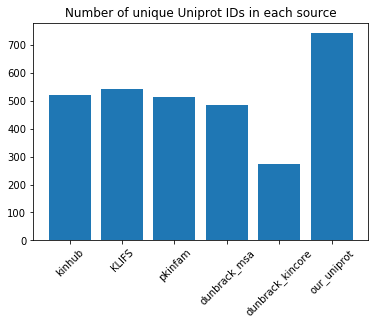

In [24]:
plt.bar(labels, y)
plt.xticks(rotation=45)
plt.title("Number of unique Uniprot IDs in each source");

Most datasets sit around the ~500 mark, with the exception of:

* Dunbrack's Kincore, since it only considers Uniprot IDs for which structural information is available
* Our handrafted query to UniProt, since it's possibly considering more IDs than needed

> TODO: Why do we obtain ~700 kinases while every other set is around ~500?

While the Uniprot set needs refinement, we will include it here to see what we are doing wrong. We won't use Kincore for now since it's probably a subset of something else.

Let's continue by analyzing the overlaps.

### 2.2 Dataset overlap

In [27]:
datasets = {
    "kinhub": kinhub,
    "klifs": klifs,
    "pkinfam": pkinfam,
    "reviewed_uniprot": reviewed_uniprot,
    "dunbrack_msa": dunbrack_msa
}
uniprot_ids = {key: set(df.UniprotID.tolist()) for key, df in datasets.items()}

With the dictionary above (`name --> set of Uniprot IDs`), we can now analyze the overlap between sets:

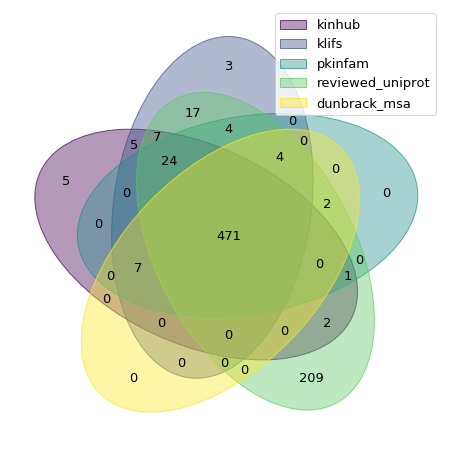

In [93]:
import venn
from venn import venn as plot_venn
v = plot_venn(uniprot_ids)
v;

In [86]:
def compute_petals(dict_of_datasets):
    """
    Function adapted from `venn._venn.generate_petal_labels`:
        https://github.com/LankyCyril/pyvenn/blob/master/venn/_venn.py#L56
    """
    from venn._venn import generate_logics
    labels = list(dict_of_datasets.keys())
    datasets = list(dict_of_datasets.values())
    n_sets = len(datasets)
    dataset_union = set.union(*datasets)
    universe_size = len(dataset_union)
    petal_labels = {}
    for logic in generate_logics(n_sets):
        included_sets = [datasets[i] for i in range(n_sets) if logic[i] == "1"]
        excluded_sets = [datasets[i] for i in range(n_sets) if logic[i] == "0" ]
        involved_labels = tuple([label for label, i in zip(labels, list(logic)) if i == "1"])
        petal_labels[involved_labels] = (dataset_union & set.intersection(*included_sets)) - set.union(set(), *excluded_sets)
    return petal_labels

In [90]:
petals = compute_petals(uniprot_ids)
for tag, values in sorted(petals.items(), key=lambda kv: len(kv[0]), reverse=True):
    if not values:
        continue
    print(f"{len(values):4d} unique Uniprot IDs in ({len(tag)}-way overlap) {', '.join(tag)}")

 471 unique Uniprot IDs in (5-way overlap) kinhub, klifs, pkinfam, reviewed_uniprot, dunbrack_msa
   4 unique Uniprot IDs in (4-way overlap) klifs, pkinfam, reviewed_uniprot, dunbrack_msa
   7 unique Uniprot IDs in (4-way overlap) kinhub, klifs, pkinfam, dunbrack_msa
  24 unique Uniprot IDs in (4-way overlap) kinhub, klifs, pkinfam, reviewed_uniprot
   2 unique Uniprot IDs in (3-way overlap) pkinfam, reviewed_uniprot, dunbrack_msa
   4 unique Uniprot IDs in (3-way overlap) klifs, pkinfam, reviewed_uniprot
   1 unique Uniprot IDs in (3-way overlap) kinhub, pkinfam, reviewed_uniprot
   7 unique Uniprot IDs in (3-way overlap) kinhub, klifs, reviewed_uniprot
  17 unique Uniprot IDs in (2-way overlap) klifs, reviewed_uniprot
   2 unique Uniprot IDs in (2-way overlap) kinhub, reviewed_uniprot
   5 unique Uniprot IDs in (2-way overlap) kinhub, klifs
 209 unique Uniprot IDs in (1-way overlap) reviewed_uniprot
   3 unique Uniprot IDs in (1-way overlap) klifs
   5 unique Uniprot IDs in (1-way ov

We can observe several interesting points here:

* There's a set of 471 kinases on which all datasets agree.
* Our ~700 kinase query (green) has 209 entries not present in any other dataset, but even more interestingly: 20 kinases were _not_ included! What are we missing?

### 2.3 Dissect the contents of each petal

Let's try to obtain information on the solitary leaves that include exclusive entries in each dataset. We can query the `petals` dictionary for information on the specific IDs. For example, which are those 3 unique IDs in KLIFS?

> Note: You need to query using _tuples_ of the dataset keys, even for single-set petals

In [91]:
petals[("klifs",)]

{'O43921', 'Q9H6X2', 'Q9UJY1'}

Thanks to the Uniprot API we can check the GO annotations if we parse the lines starting with `DR   GO` that also contain `F:` (for function-related annotations):

In [92]:
for i, entry in enumerate(petals[("klifs",)], 1):
    r = requests.get(fr"https://www.uniprot.org/uniprot/{entry}.txt")
    r.raise_for_status()
    print(i, entry)
    for line in r.text.splitlines():
        if line.startswith(("ID", "DE")):
            print(line)
        elif line.startswith("DR   GO;") and "; F:" in line:
            print(line)
    print()

1 O43921
ID   EFNA2_HUMAN             Reviewed;         213 AA.
DE   RecName: Full=Ephrin-A2;
DE   AltName: Full=EPH-related receptor tyrosine kinase ligand 6;
DE            Short=LERK-6;
DE   AltName: Full=HEK7 ligand;
DE            Short=HEK7-L;
DE   Flags: Precursor;
DR   GO; GO:0046875; F:ephrin receptor binding; IBA:GO_Central.

2 Q9H6X2
ID   ANTR1_HUMAN             Reviewed;         564 AA.
DE   RecName: Full=Anthrax toxin receptor 1;
DE   AltName: Full=Tumor endothelial marker 8;
DE   Flags: Precursor;
DR   GO; GO:0051015; F:actin filament binding; IDA:UniProtKB.
DR   GO; GO:0005518; F:collagen binding; IDA:UniProtKB.
DR   GO; GO:0046872; F:metal ion binding; IEA:UniProtKB-KW.
DR   GO; GO:0004888; F:transmembrane signaling receptor activity; IDA:UniProtKB.

3 Q9UJY1
ID   HSPB8_HUMAN             Reviewed;         196 AA.
DE   RecName: Full=Heat shock protein beta-8;
DE            Short=HspB8;
DE   AltName: Full=Alpha-crystallin C chain;
DE   AltName: Full=E2-induced gene 1 protei

> TODO: Examine the petals to gather information on the specific details behind each kinase selection criterion
> Some questions we want to ask:
> * Why are we missing kinases in our over-reaching Uniprot query?
> * Why are only KLIFS / KinHub selecting those?

## 3. Generate outputs

Since there'no agreement to what a kinase *is*, we will output everything already considered by the five listings we have analyzed.

Let's build the final dataframe with all kinases:

In [137]:
kinases = pd.concat(
    [
        kinhub[["HGNC Name", "UniprotID"]].rename(columns={"HGNC Name": "Name"}).assign(kinhub=1), 
        klifs[["HGNC Name", "UniprotID"]].rename(columns={"HGNC Name": "Name"}).assign(klifs=1), 
        pkinfam[["Name", "UniprotID"]].assign(pkinfam=1), 
        reviewed_uniprot[["Entry name", "UniprotID"]].rename(columns={"Entry name": "Name"}).assign(reviewed_uniprot=1),
        dunbrack_msa[["4_Uni_entry", "UniprotID"]].rename(columns={"4_Uni_entry": "Name"}).assign(dunbrack_msa=1)
    ]
)
kinases

/home/jaime/.conda/envs/kinoml/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,Name,UniprotID,dunbrack_msa,kinhub,klifs,pkinfam,reviewed_uniprot
336,AAK1,Q2M2I8,NaN,1.0,NaN,NaN,NaN
0,ABL1,P00519,NaN,1.0,NaN,NaN,NaN
24,ABL2,P42684,NaN,1.0,NaN,NaN,NaN
529,ABR,Q12979,NaN,1.0,NaN,NaN,NaN
1,TNK2,Q07912,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
492,TYK2_HUMAN,P29597,1.0,NaN,NaN,NaN,NaN
493,TYK2_HUMAN,P29597,1.0,NaN,NaN,NaN,NaN
494,TYRO3_HUMAN,Q06418,1.0,NaN,NaN,NaN,NaN
495,YES_HUMAN,P07947,1.0,NaN,NaN,NaN,NaN


Since there are different names assigned to each Uniprot ID depending on the source, we will just concatenate them in the same column

In [150]:
keys = ["kinhub", "klifs", "pkinfam", "reviewed_uniprot", "dunbrack_msa"]
kinases["Name"] = kinases.transform({'Name': lambda v: v.replace("_HUMAN", "")})
boolsum = lambda v: v.sum() > 0
joinset = lambda v: '|'.join([x for x in set(v) if x])
grouped = kinases.groupby(["UniprotID"], as_index=False).agg(dict(**{'Name': joinset}, **{k: boolsum for k in keys}))
grouped

,UniprotID,Name,kinhub,klifs,pkinfam,reviewed_uniprot,dunbrack_msa
0,A0A0B4J2F2,SIK1B,False,False,True,True,True
1,A2A3N6,PIPSL,False,False,False,True,False
2,A2RU49,HYKK,False,False,False,True,False
3,A4D2B8,PM2P1,False,False,False,True,False
4,A4QPH2,PI4KAP2|PI4P2,False,True,False,True,False
...,...,...,...,...,...,...,...
756,Q9Y6K8,KAD5,False,False,False,True,False
757,Q9Y6M4,KC1G3|CSNK1G3,True,True,True,True,True
758,Q9Y6R4,M3K4|MAP3K4,True,True,True,True,True
759,Q9Y6S9,RPKL1|RPS6KL1,True,True,True,True,True


In [151]:
# example Uniprot ID with different names
grouped[grouped.UniprotID == "Q96LW2"]

,UniprotID,Name,kinhub,klifs,pkinfam,reviewed_uniprot,dunbrack_msa
594,Q96LW2,SGK494|RSKR|KS6R,True,True,True,True,True


We'll export the multi-kinase dataframe to a CSV in the repo:

In [152]:
grouped.to_csv(DATA / "human_kinases.aggregated.csv")